In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import os
import PIL
import PIL.Image
import pathlib
import math
import copy


## Preprocessing

In [3]:
 def downscale_images(images, scale=30):
    """
    Downscales images in an array.
    Args:
        images: array of images to be downscaled 
        scale: 

    Returns: array of downscaled down images

    """
    resized = []
    
    for img in images:
        
        width = int(img.shape[1] * scale / 100)
        height = int(img.shape[0] * scale / 100)
        dim = (width, height)

        resized.append(cv2.resize(img, dim, interpolation = cv2.INTER_AREA))
    
    return resized


In [4]:
def load_and_preprocess(path):
    
    # directory with the images
    data_dir = pathlib.Path(path)
    
    
    # how many images are in the directory
    image_count = len(list(data_dir.glob('*')))
    print(f"Number of images found in {path}: {image_count}")


    paintings_path = list(data_dir.glob('*'))
    paintings_path = [str(path) for path in paintings_path]
    
    # loading images, in BGR
    paintings = [cv2.imread(painting_path) for painting_path in paintings_path]
    paintings = downscale_images(paintings)
    
    
    # converting to gray
    paintings_gray = [cv2.cvtColor(painting, cv2.COLOR_BGR2GRAY) for painting in paintings]
    
    # converting to RGB for later visualisation
    paintings_rgb = [cv2.cvtColor(painting, cv2.COLOR_BGR2RGB) for painting in paintings]
    
    painting_tuple = (paintings_gray, paintings_rgb)
    
    return painting_tuple


## Loading stolen paintings

In [5]:
stolen_art_dir_path = "./mydata-stolen/"
stolen_paintings = load_and_preprocess(stolen_art_dir_path)


Number of images found in ./mydata-stolen/: 9


## Loading found paintings
Paintings which I want to test against the stolen images.

In [6]:
found_paintings_dir_path = "./mydata-found/" 
found_paintings = load_and_preprocess(found_paintings_dir_path)

Number of images found in ./mydata-found/: 17


In [7]:
def display_compared(img1, img2):
    # Display traning image and testing image
    fx, plots = plt.subplots(1, 2, figsize=(20,10))

    plots[0].set_title("Stolen Image")
    plots[0].imshow(img1)

    plots[1].set_title("Comparing to")
    plots[1].imshow(img2)

## Scaling functions for visualisation

Functions mainly for downscaling the paintings/keypoints before visualisation. Greatly reduces the size of the notebook.

In [8]:
def features_deepcopy (f):
    return [cv2.KeyPoint(x = k.pt[0], y = k.pt[1], 
            _size = k.size, _angle = k.angle, 
            _response = k.response, _octave = k.octave, 
            _class_id = k.class_id) for k in f]

In [9]:
def scale_keypoints(keypoints, scale):
    
    for keypoint in keypoints:
        new_x = math.trunc(keypoint.pt[0]*(scale/100) )
        new_y = math.trunc(keypoint.pt[1]*(scale/100) )
        keypoint_scaled = (new_x, new_y) 
        keypoint.pt = keypoint_scaled
    

In [10]:
def draw_matches_scaled(found_painting, found_painting_keypoints,
                        stolen_painting, stolen_painting_keypoints,
                        matches, matchesMask, draw_params, scale = 20):
    
    # scale the paintings
    found_painting = downscale_images([found_painting], scale)[0]
    stolen_painting = downscale_images([stolen_painting], scale)[0]
    
    found_painting_keypoints_scaled = features_deepcopy(found_painting_keypoints)
    scale_keypoints(found_painting_keypoints_scaled, scale)
    
    stolen_painting_keypoints_scaled = features_deepcopy(stolen_painting_keypoints)
    scale_keypoints(stolen_painting_keypoints_scaled, scale)

    result = cv2.drawMatchesKnn(found_painting, found_painting_keypoints_scaled,
                                stolen_painting, stolen_painting_keypoints_scaled,
                                matches, None, **draw_params)
    
    return result

    

# ORB

In [11]:
# Creating an ORB object
orb = cv2.ORB_create(nfeatures=500)

In [12]:
def visualize_keypoints(image, keypoints, scale = 100):
    
    # SCALE HAS TO BE 100, TODO
    
    keypoints_without_size = np.copy(image)
    keypoints_with_size = np.copy(image)

    keypoints_without_size = downscale_images([keypoints_without_size], scale)[0]
    keypoints_with_size = downscale_images([keypoints_with_size], scale)[0]
    
    keypoints_scaled = features_deepcopy(keypoints)
    scale_keypoints(keypoints_scaled, scale)
    
    cv2.drawKeypoints(image, keypoints_scaled, keypoints_without_size, color = (0, 255, 0))

    cv2.drawKeypoints(image, keypoints_scaled, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    
    # Display image with and without keypoints size
    fx, plots = plt.subplots(1, 2, figsize=(20,10))

    plots[0].set_title("Train keypoints With Size")
    plots[0].imshow(keypoints_with_size)

    plots[1].set_title("Train keypoints Without Size")
    plots[1].imshow(keypoints_without_size)
    
    print("Number of Keypoints Detected In The Stolen Image: ", len(keypoints))

## Running the algorithm

Find keypoints on every image in the database. Display the keypoints with their size (left) and without (right).

In [13]:
orb_results = []

for index, _ in enumerate(stolen_paintings[0]):

    orb_res = orb.detectAndCompute(stolen_paintings[0][index], None)
    orb_results.append(orb_res)

    sp_keypoints, sp_descriptors = orb_res
    
    #visualize_keypoints(stolen_paintings[1][index], sp_keypoints, scale=100)

# Searching for a painting in the database

In [14]:
def search_for_painting(painting_index):
    
    found_painting = found_paintings[0][painting_index]
    found_painting_rgb = found_paintings[1][painting_index]
    found_painting_keypoints, found_painting_descriptor = orb.detectAndCompute(found_painting, None)

    best_match_index, matches, mask = get_best_match(found_painting_descriptor)
    
    if best_match_index < 0:
        print("Sorry, no match found for painting: ")
        plt.imshow(found_paintings[1][image_index])
        return
    
    draw_matches(best_match_index, found_painting_rgb, found_painting_keypoints, matches, mask)
    

## FLANN Based Matcher

In [15]:
# 1. parametr FlannBasedMatcheru
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

In [16]:
# 2. parametr FlannBasedMatcheru
search_params = dict(checks=50)   # or pass empty dictionary

In [17]:
def get_best_match(found_painting_descriptor, k = 2, min_matches = 10):

    matches_count = {}
    
    matches = {}
    matches[-1] = None
    
    matches_masks = {}
    matches_masks[-1] = None
    
    
    for index, stolen_res in enumerate(orb_results):
        stolen_keypoints, stolen_descriptor = stolen_res

        # Cross check parametr
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Perform the matching between the ORB descriptors of the training image and the test image
        matches[index] = flann.knnMatch(stolen_descriptor, found_painting_descriptor, k)
        # deskriptor = "fingerprint" keypointu, vektor 0 a 1, napr. BRIEF rozmaze misto a z toho spocita vektor
        # ORB muze pouzivat rBRIEF, tzn. pocita i s rotaci obrazu

        ok_matches_num = 0

        # Need to draw only good matches, so create a mask
        matches_masks[index] = [[0,0] for i in range(len(matches[index]))]
        # ratio test as per Lowe's paper
        for i, candidates in enumerate(matches[index]):
            if (len(candidates)<2):
                continue # nedostatek bodu pro porovnani
            m, n = candidates    
            if m.distance < 0.7*n.distance:
                matches_masks[index][i]=[1,0]
                ok_matches_num = ok_matches_num + 1 
        
        matches_count[index] = ok_matches_num
        
    
        
        # print("Pocet prijatelnych matchu: ", ok_matches_num)
        
    best_match_index = max(matches_count, key=matches_count.get)
    #print(type(best_match_index))
    best_match_index = best_match_index if matches_count[best_match_index] >= min_matches else -1
        
    return best_match_index, matches[best_match_index], matches_masks[best_match_index] 

In [18]:
def draw_matches(stolen_index, found_painting, found_painting_keypoints, matches, matchesMask):
    
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = cv2.DrawMatchesFlags_DEFAULT)

    
    
    result = draw_matches_scaled(found_painting, found_painting_keypoints,
                                 stolen_paintings[1][stolen_index], orb_results[stolen_index][0],
                                 matches, matchesMask, draw_params)
    
    # Display the best matching points
    plt.rcParams['figure.figsize'] = [28.0, 14.0]
    plt.title('Painting found! Best match: ')
    plt.imshow(result)
    plt.show()

# Testing the algorithm on all the paintings

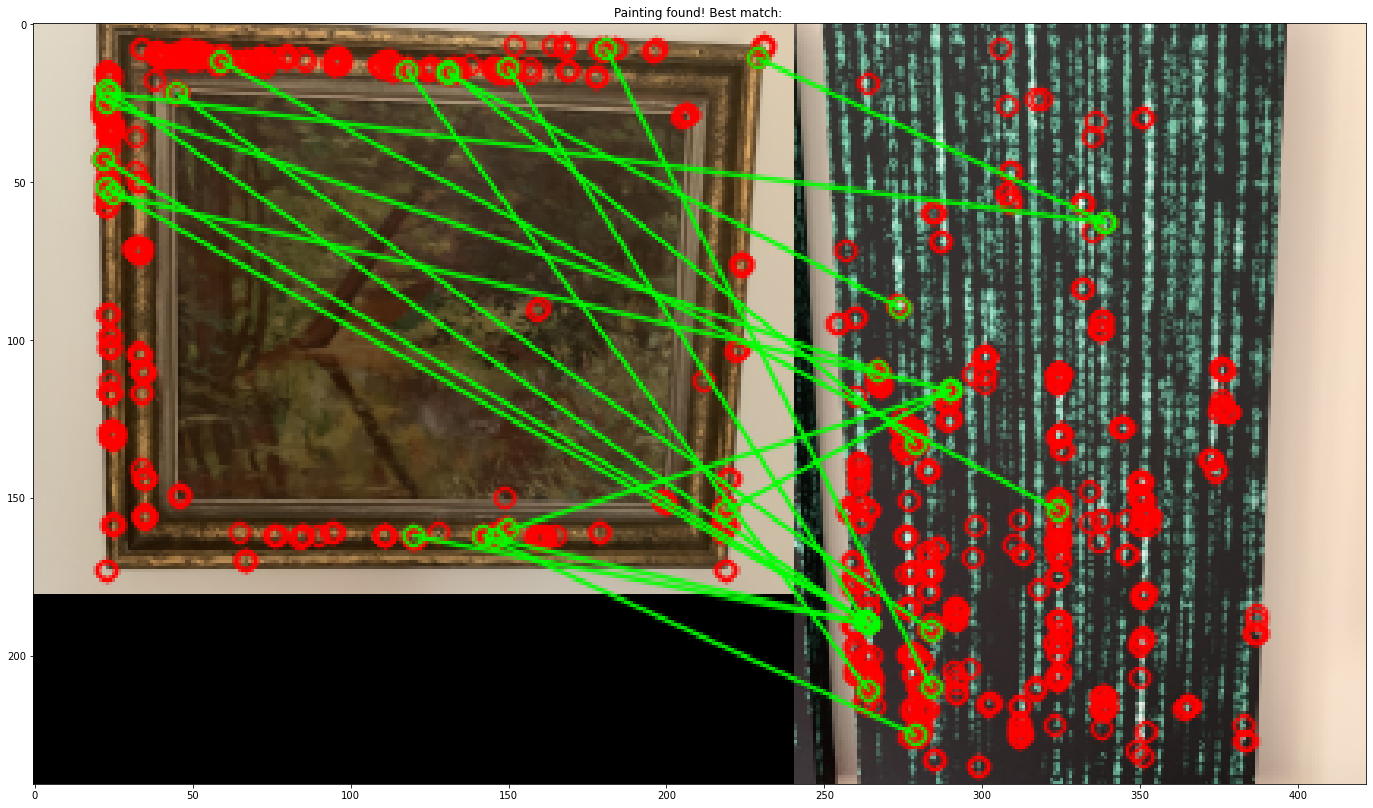

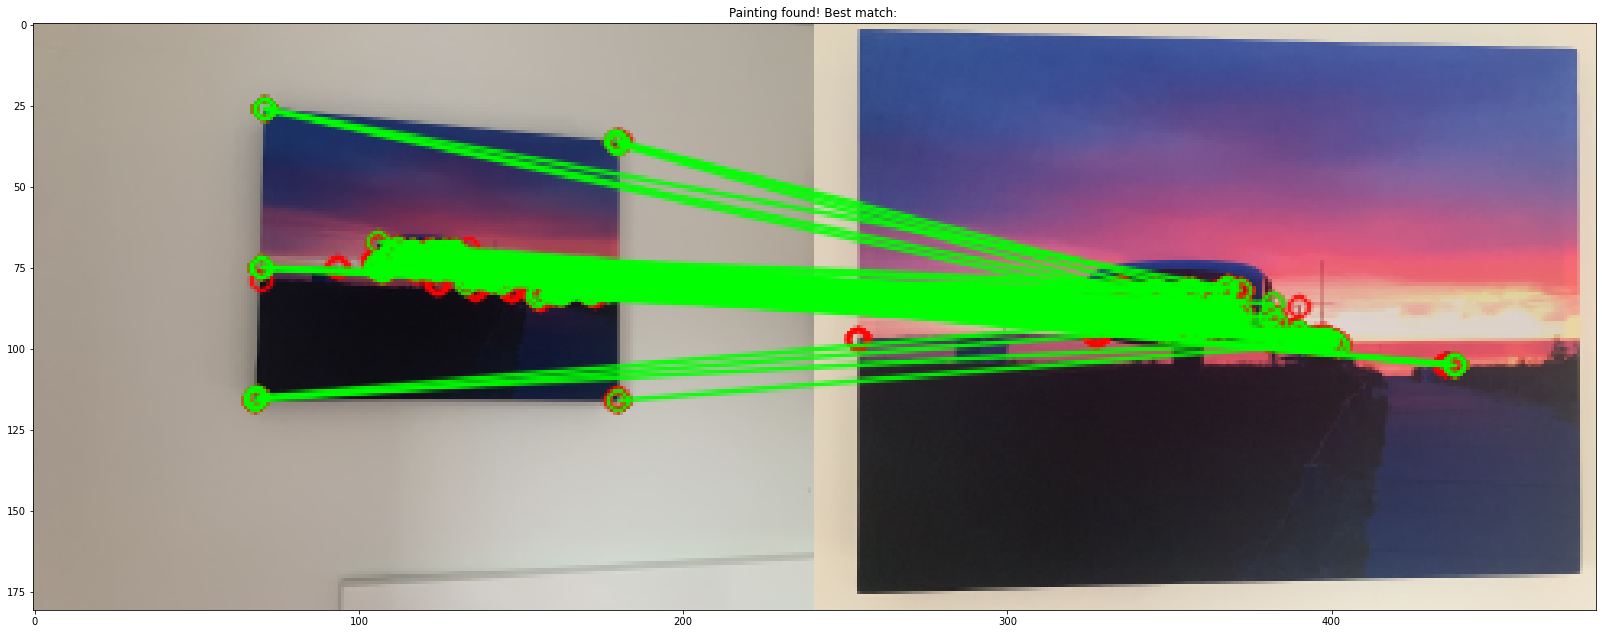

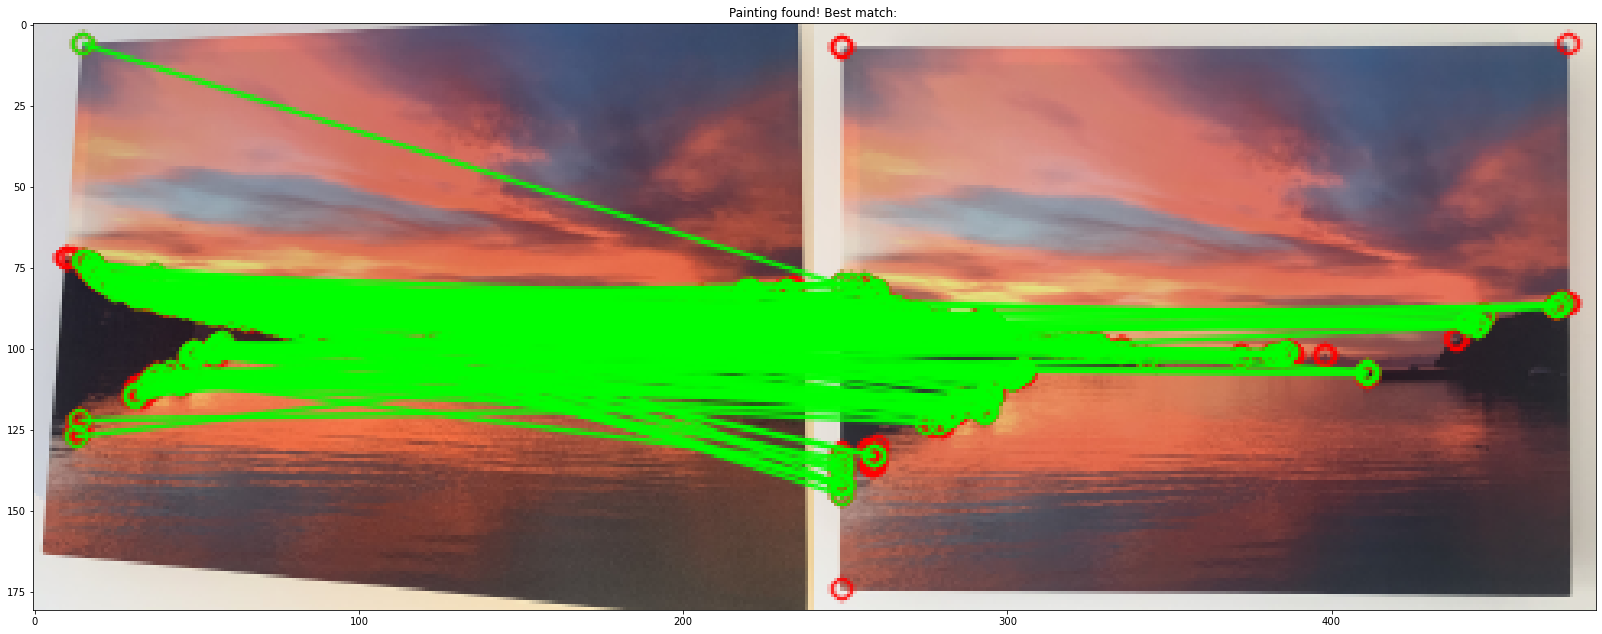

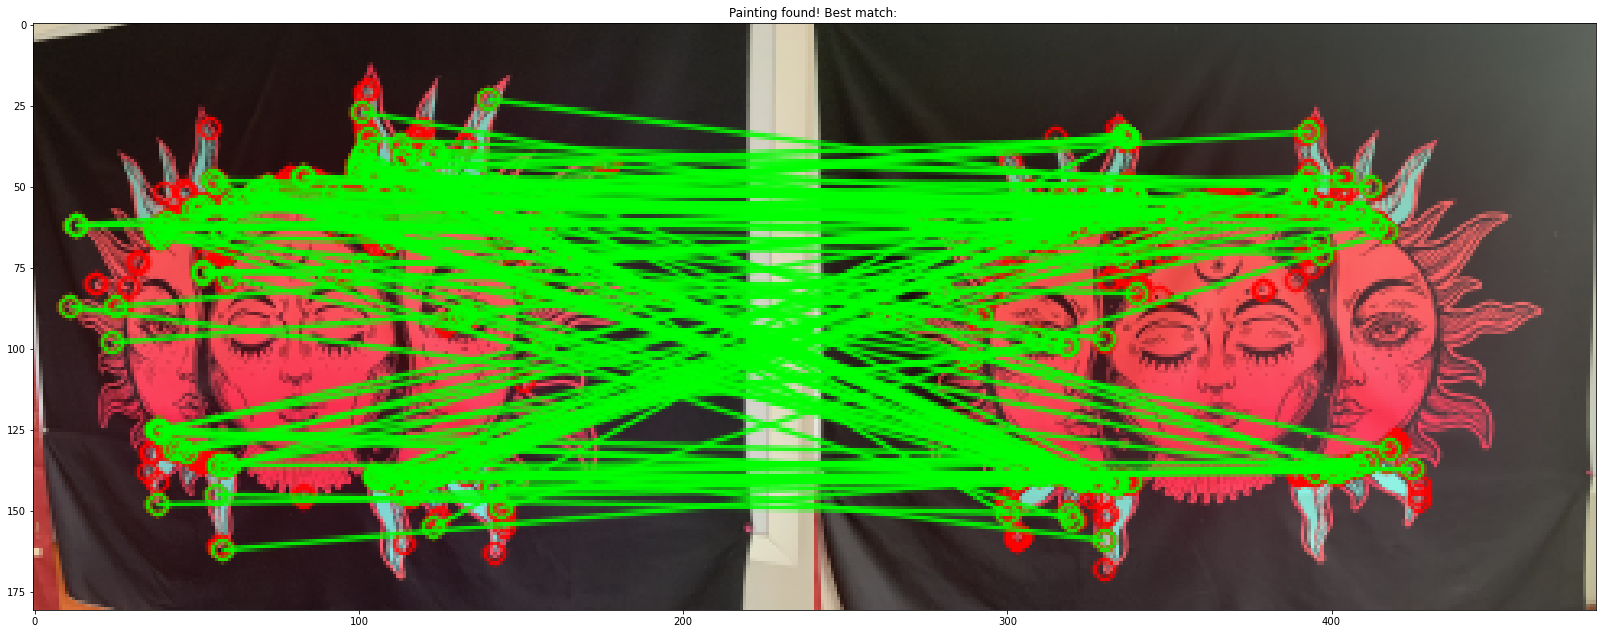

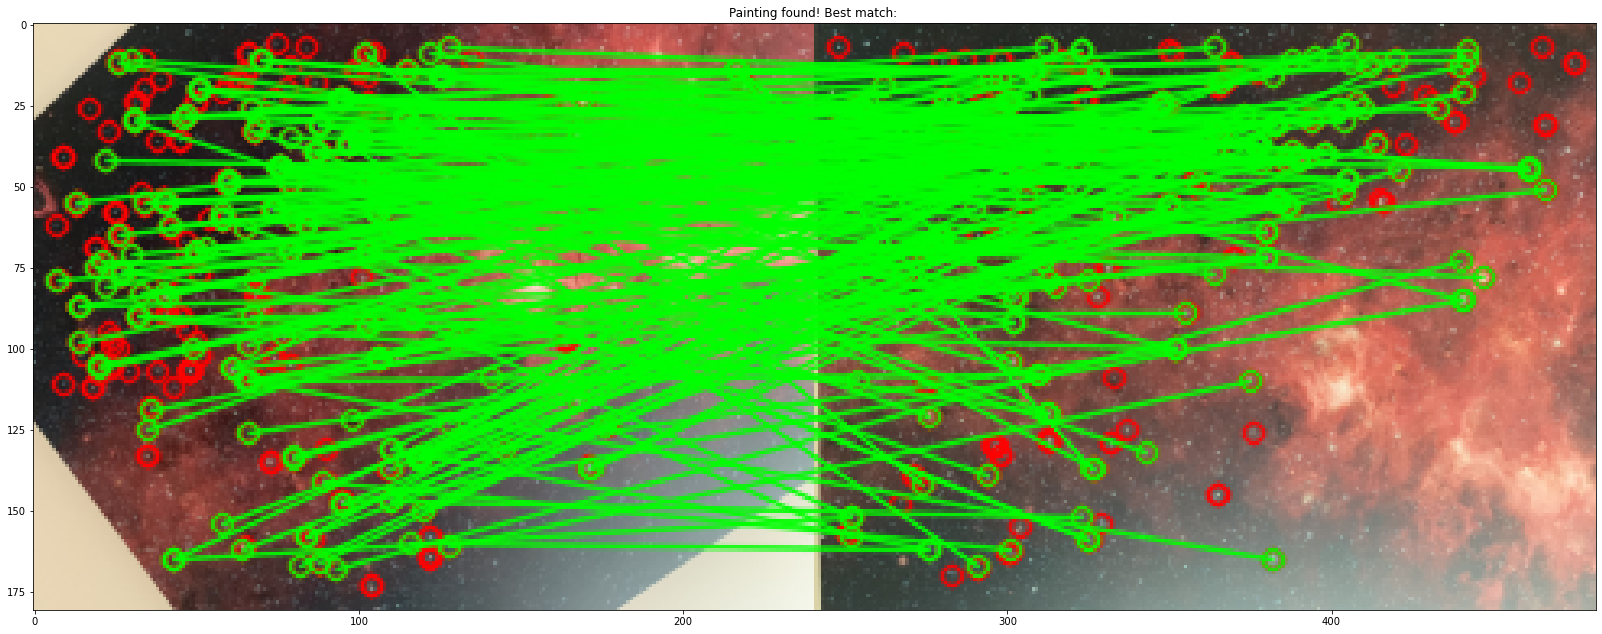

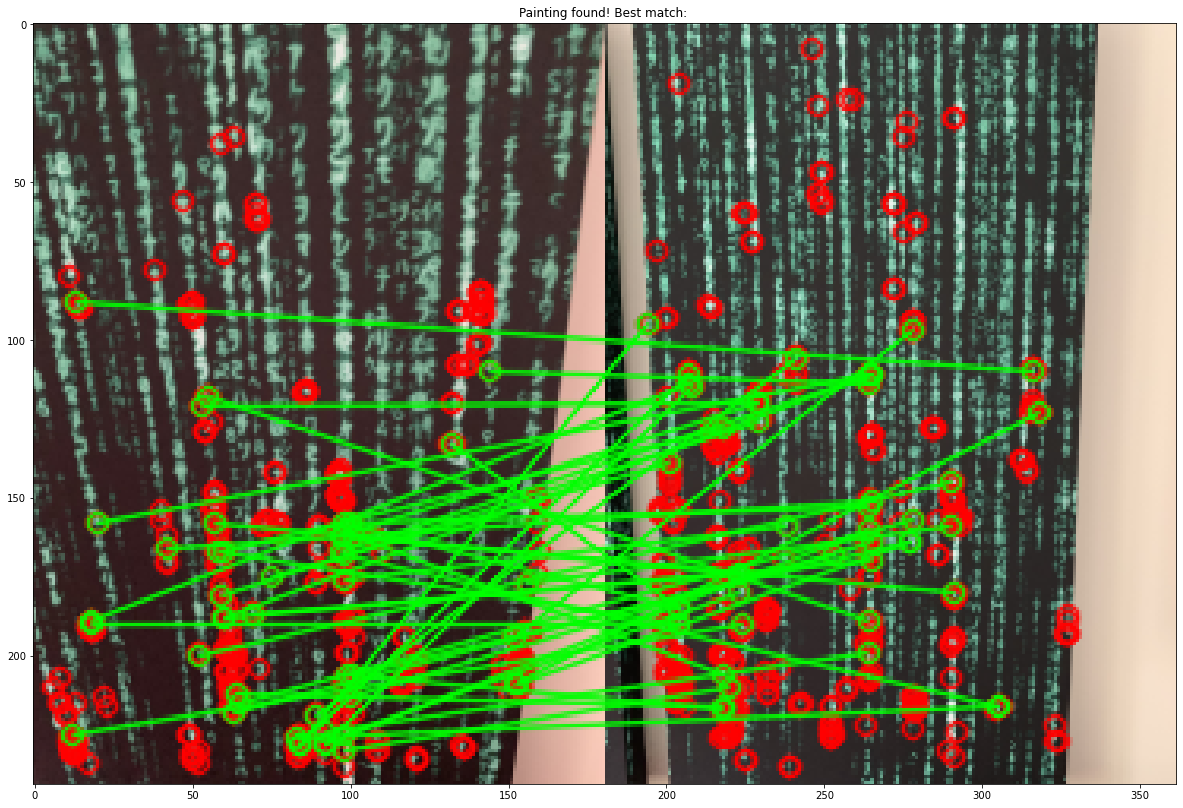

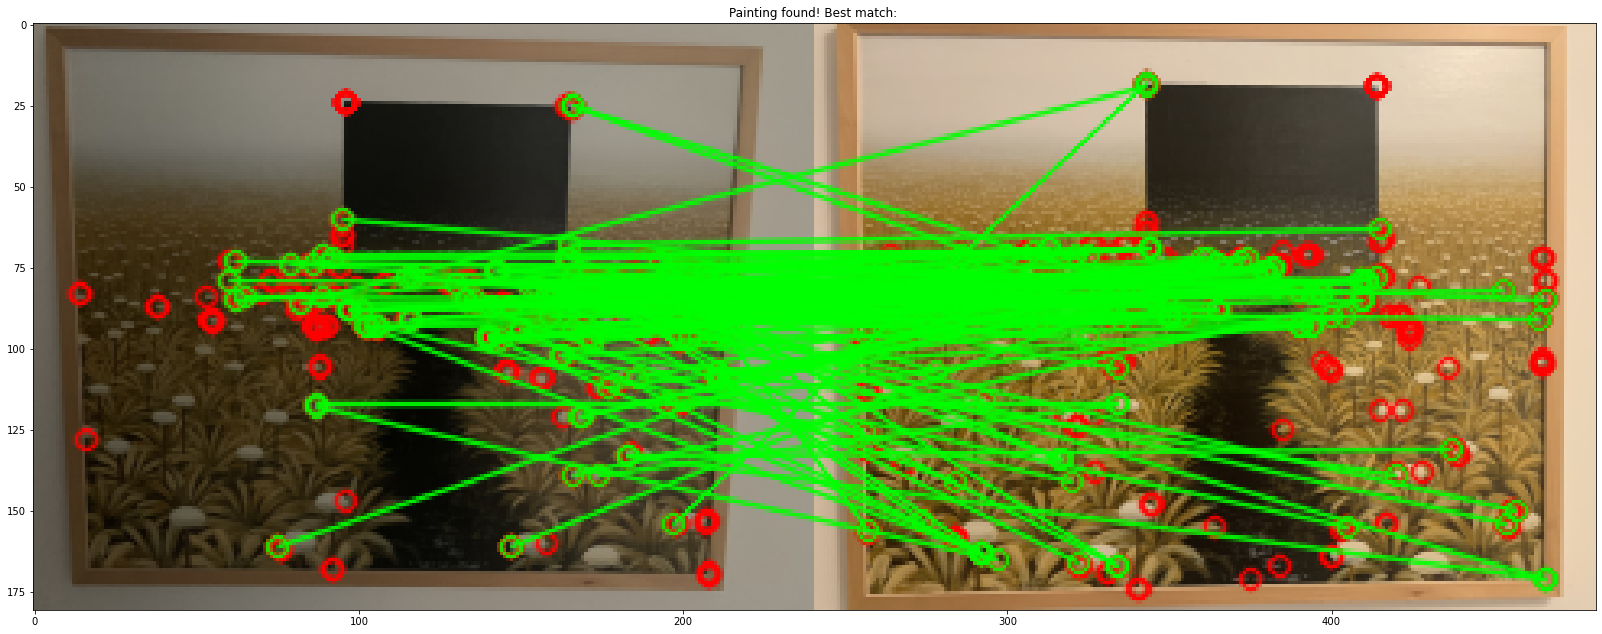

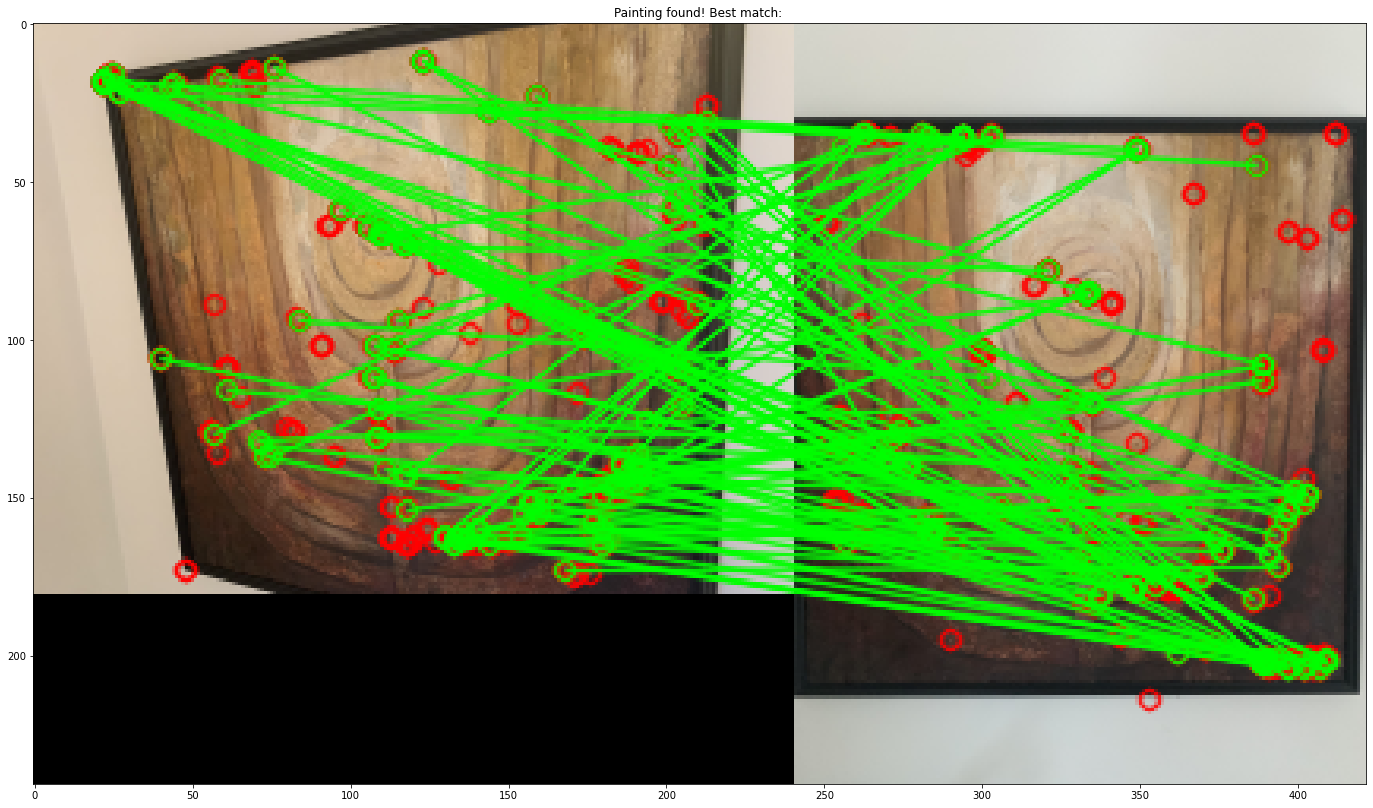

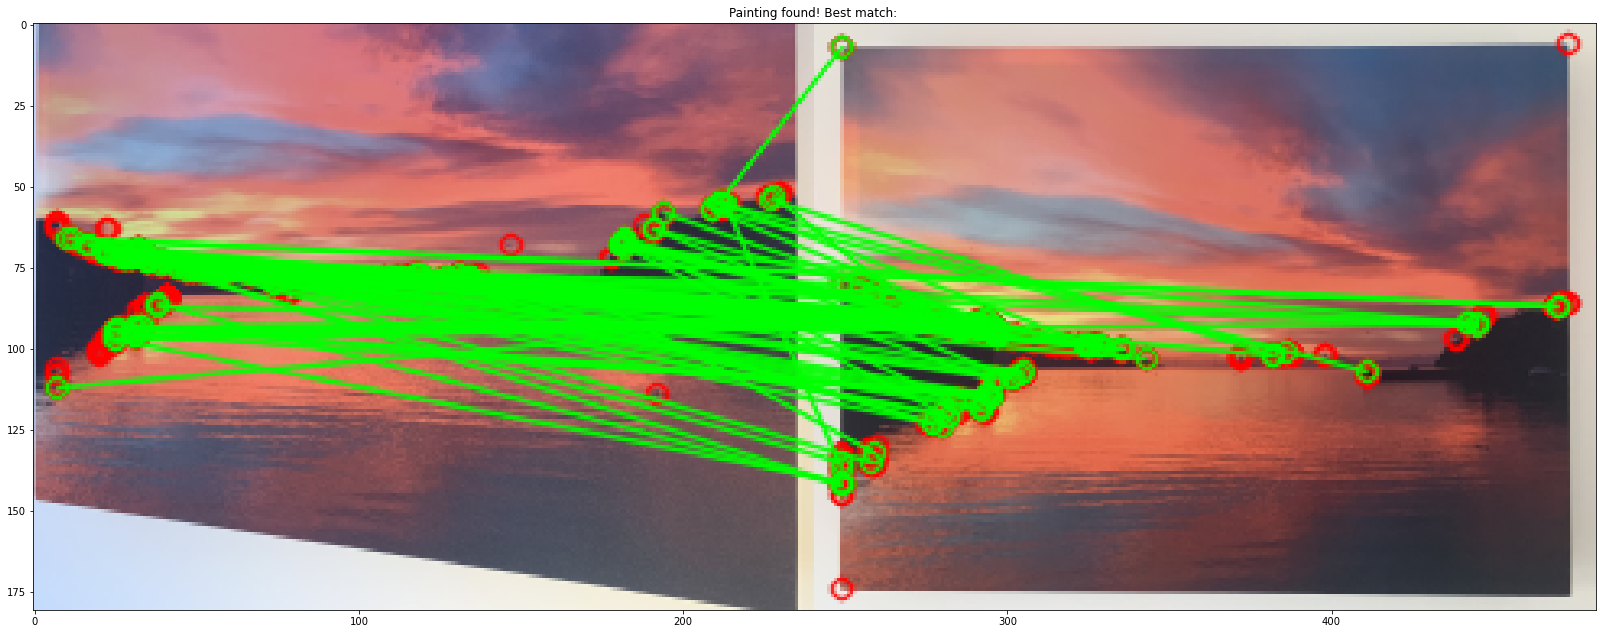

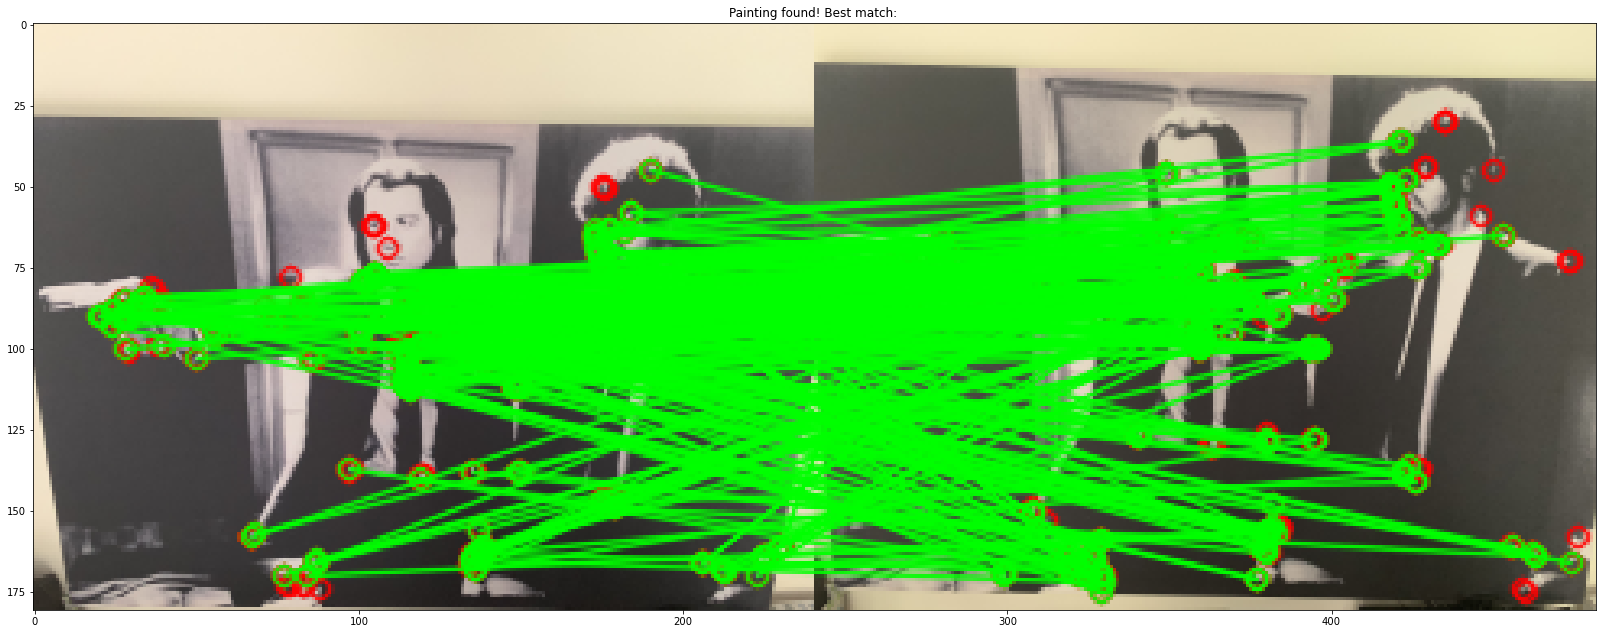

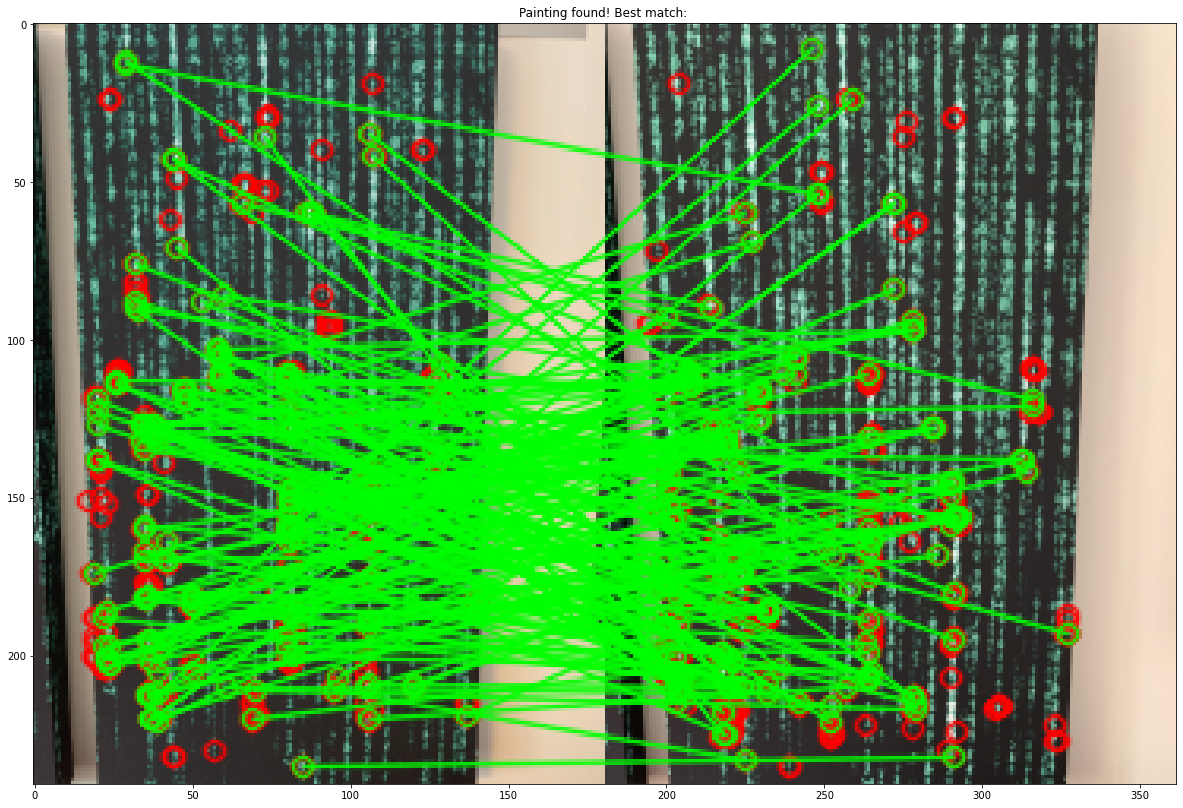

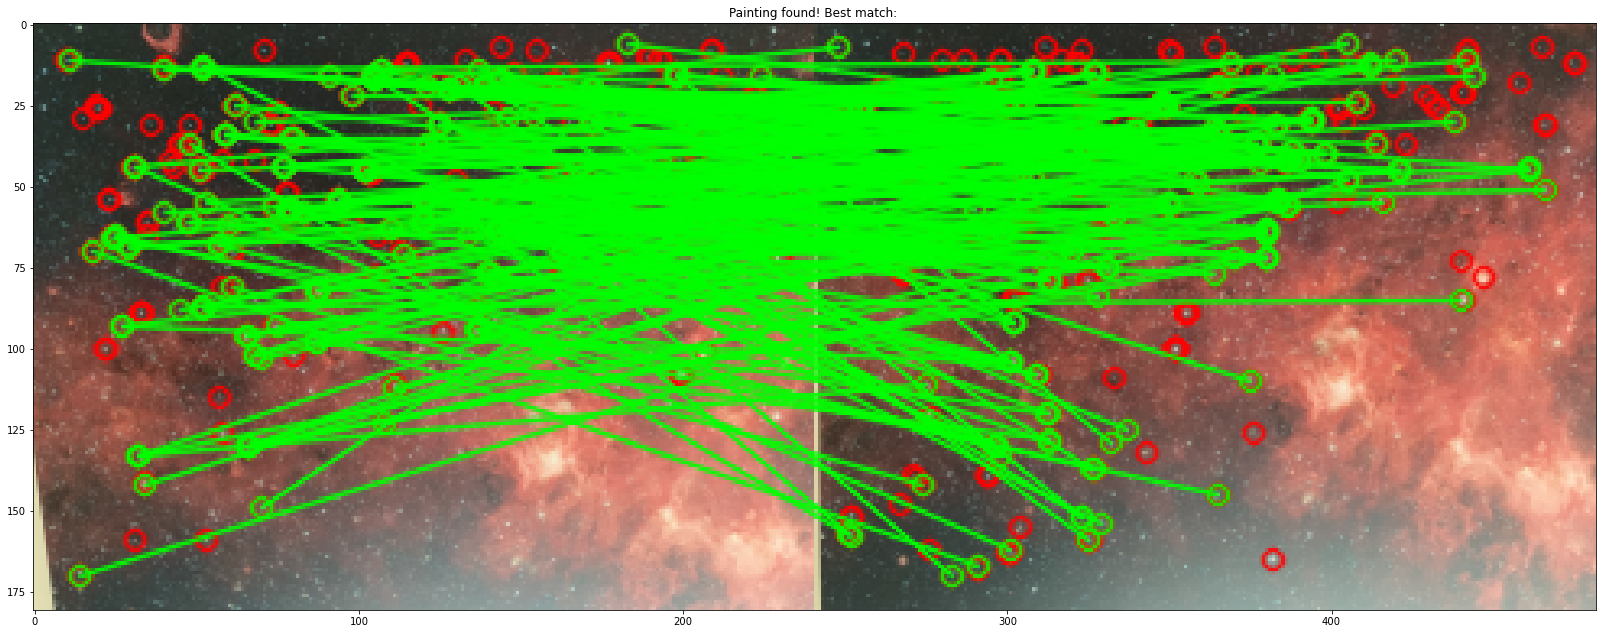

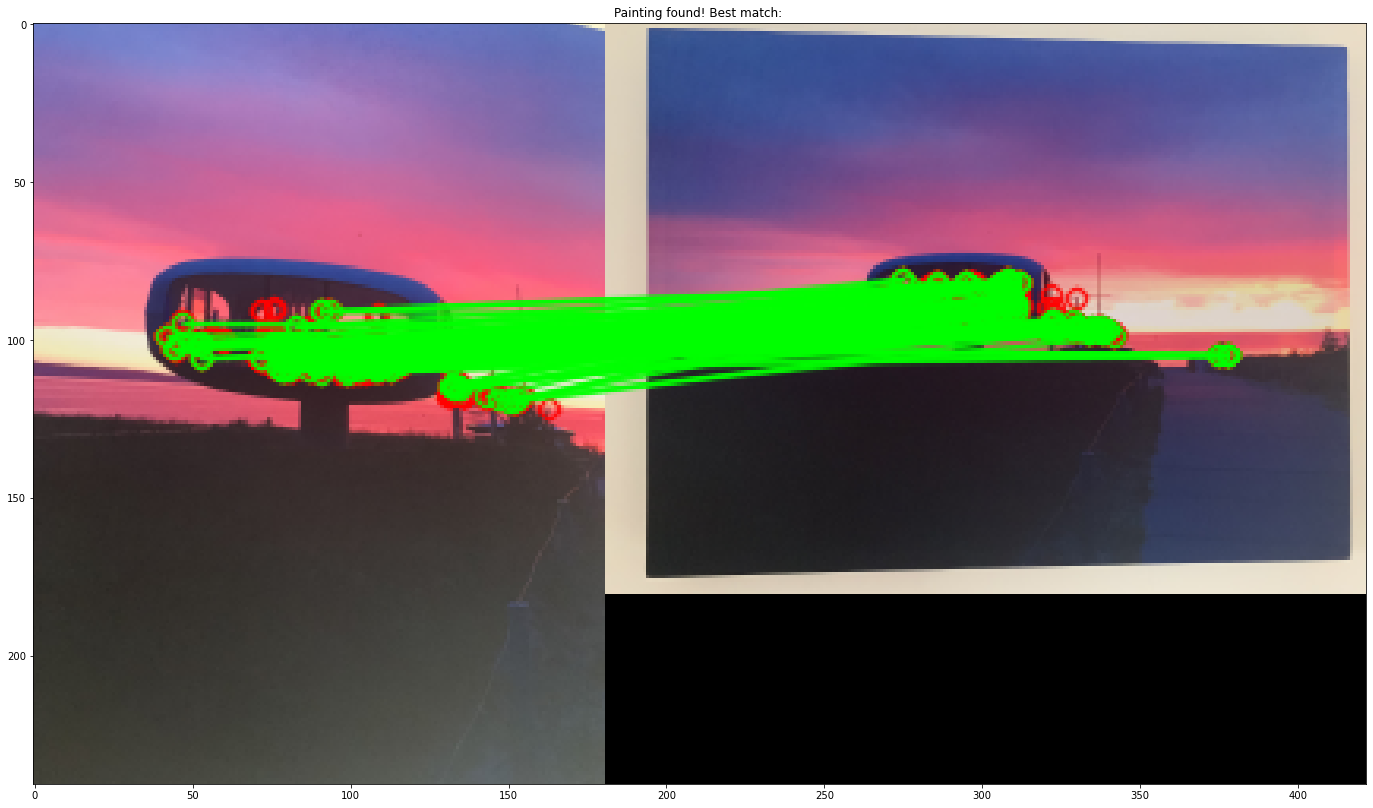

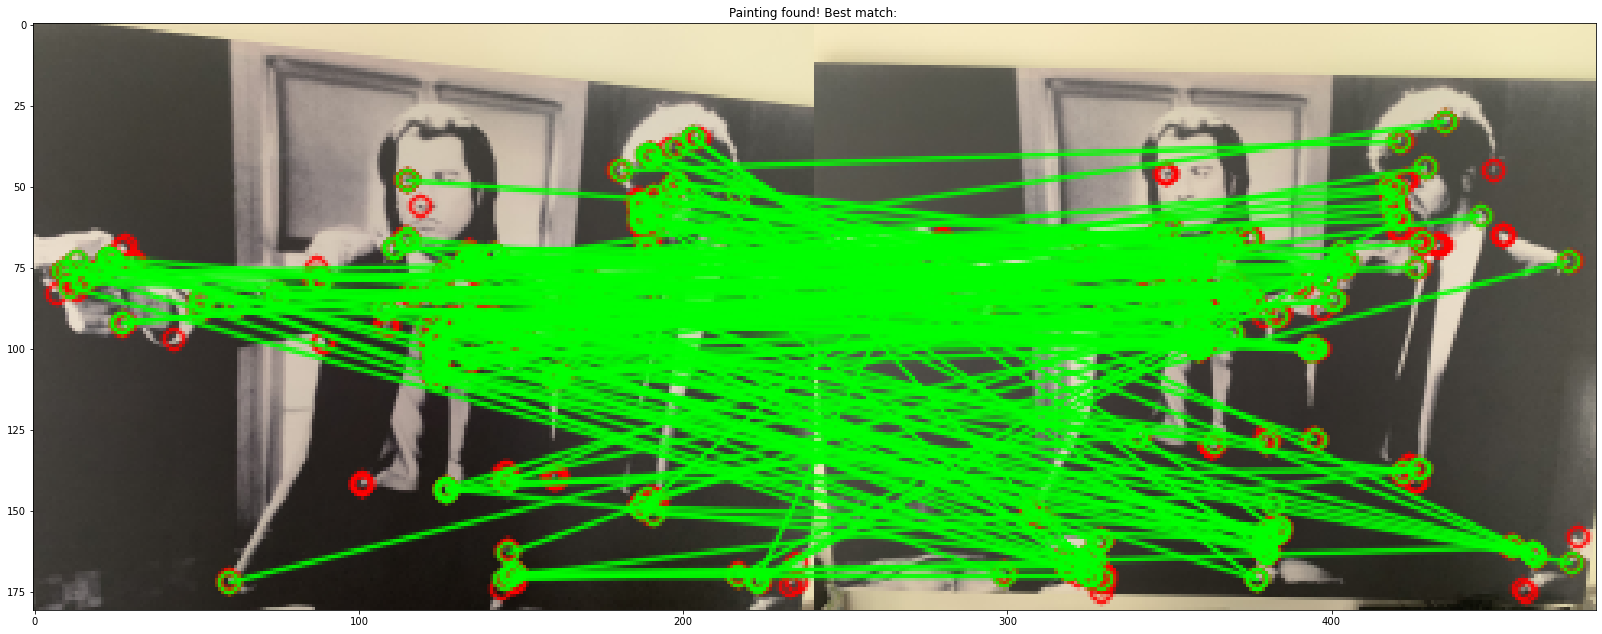

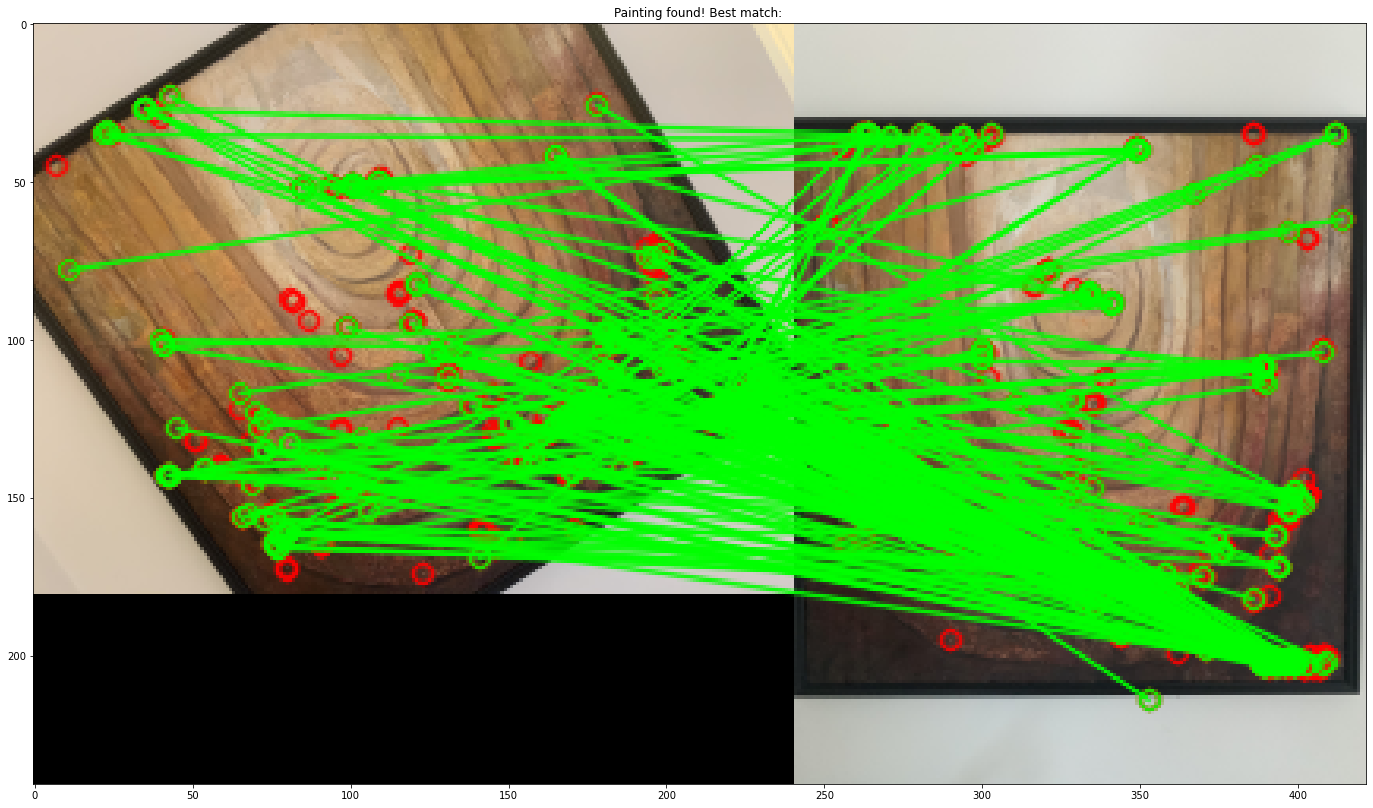

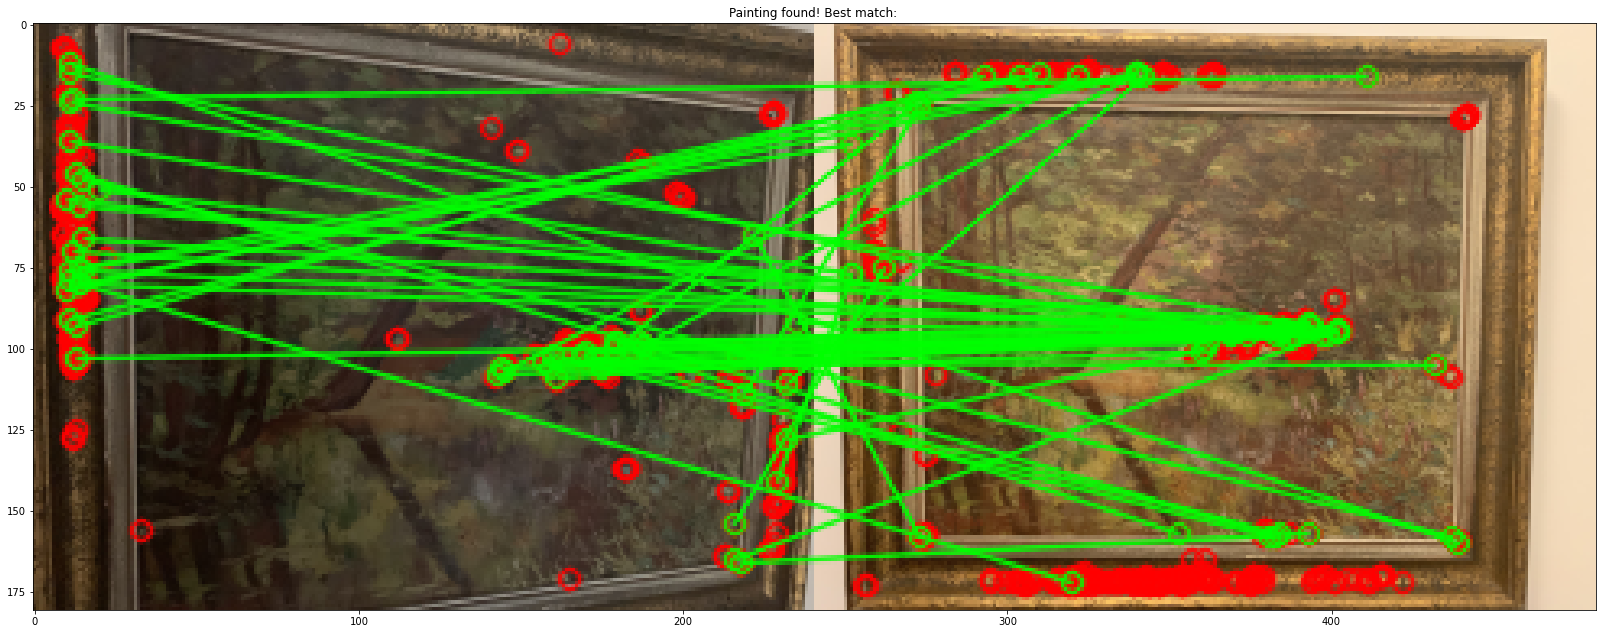

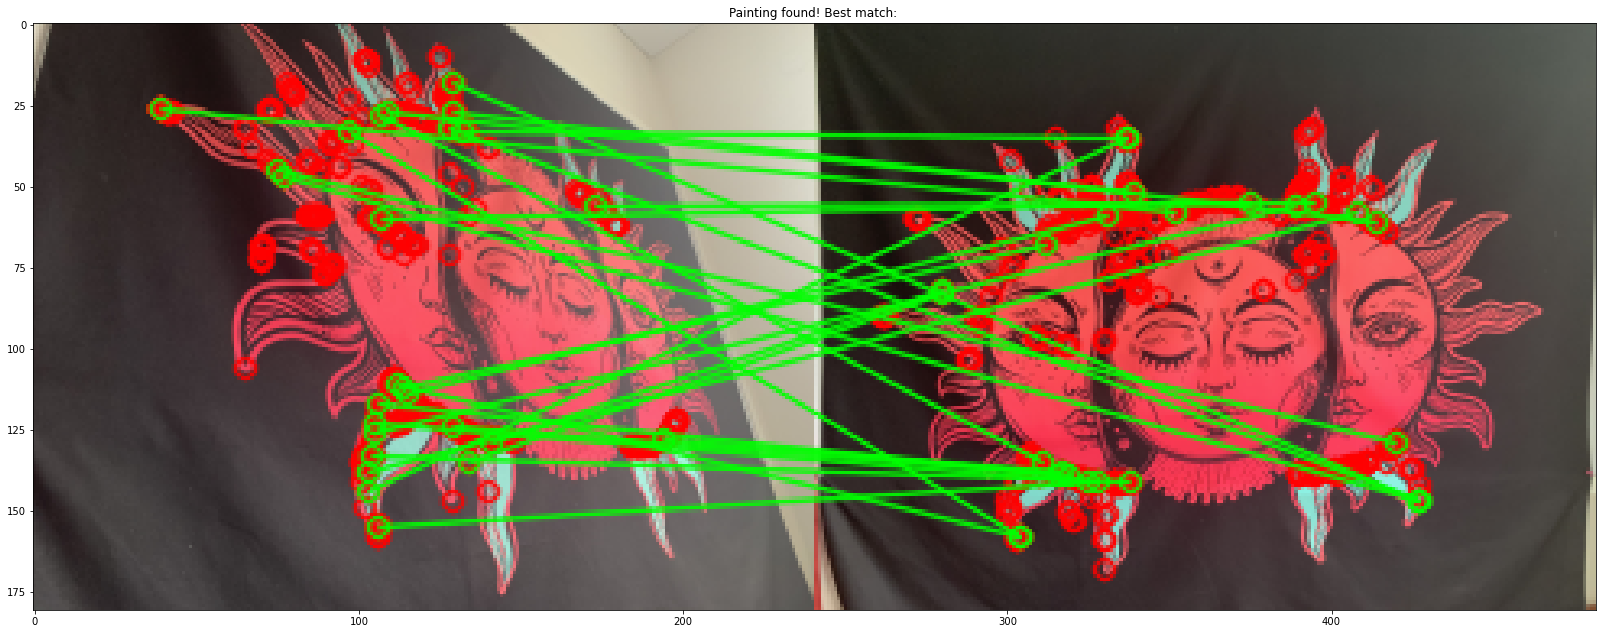

In [19]:
for index in range(0, len(found_paintings[0])):
    search_for_painting(index)


In [20]:
# nápad na vylepšení: porovnávat směry vektoru, vyhodit outsidery
# + zkoumat relativni polohu

## Matching nalezeného obrazu s obrazy v DB  pomocí Brute Force Matcher


BFMatcher - Obsahuje parametr crossCheck, údajně dobrá alternativa k ratio testu, ale mně nefunguje dobře. Znamená to, že namatchuje pouze body, které jsou si nejpodobnější navzájem, tzn. pro žádný z dvojice neexistuje v druhém obraze lepší match. Pokud ho dám na False, matcher namatchuje všechny body a výsledek je uplně k ničemu. Pokud na true, matcher namatchuje cca polovinu bodů, ale u všech obrazů a je proto taky k ničemu.

Mnohem lépe se mi osvědčila kombinace knnMatch a ratio testu.

**crossCheck se samozřejmě nedá kombinovat s knnMatch ! !**




zdroj: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

In [21]:
kbfm = 2

for index, stolen_res in enumerate(orb_results):
    stolen_keypoints, stolen_descriptor = stolen_res

    # Cross check parametr
    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck = False)

        
    
    # Perform the matching between the ORB descriptors of the training image and the test image
    matches = bf.knnMatch(stolen_descriptor, suspect_descriptor, kbfm)
    # deskriptor = "fingerprint" keypointu, vektor 0 a 1, napr. BRIEF rozmaze misto a z toho spocita vektor
    # ORB muze pouzivat rBRIEF, tzn. pocita i s rotaci obrazu
    
   
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    result = cv2.drawMatchesKnn(stolen_paintings[1][index], stolen_keypoints, suspected_painting_rgb, suspect_keypoints, good, None, flags = 2)
    
    # Display the best matching points
    plt.rcParams['figure.figsize'] = [28.0, 14.0]
    plt.title('Best Matching Points')
    plt.imshow(result)
    plt.show()

    # Print total number of matching points between the training and query images
    print("Celkový počet dobrých match (po ratio testu): ", len(good))

NameError: name 'suspect_descriptor' is not defined